<span style="font-size:2em;">[Kaggle competition: IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/overview) </span>

Can we detect fraud from customer transactions? Lessons from my first competition
***
**<span style="font-size:1.5em;">Motivation</span>**


After having spent a lot of time taking data science classes, I was eager to start practicing on a real dataset and to enter a Kaggle competition. I am thankful that I did because in the process, I learned a lot of things that aren't covered in those classes. Techniques like stratified cross validation, increasing the memory efficiency of my dataset, model stacking and blending, were all new to me.   

I also applied techniques learnt in Fastai's Intro to machine learning course which I'll comment on throughout the notebook. I highly recommend this course if you are learning like me. 

Even though my ranking was nothing impressive (top 60%), I now understand what it takes to create a state of the art kernel and have learned the tools to do so intelligently and efficiently. 

I am sharing my solution, methodology and a bunch of efficient helper functions as a way to anchor these learnings and for beginners who want to get better.

# About this dataset

In this competition we are predicting the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud`. The data comes from [Vesta Corporation's](https://trustvesta.com/) real-world e-commerce transactions and contains a wide range of features from device type to product features.

The data is broken into two files: identity and transaction, which are joined by `TransactionID`.

> Note: Not all transactions have corresponding identity information.



**Evaluation**

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


# Methodology

**1. Quick cleaning and modeling**.
When starting off with a dataset with as many columns as this one (over 400), we'll want to quickly run it through an ensemble learner, forgoing any exploratory data analysis and feature engineering at the beginning. Once the model is fit to the data, we'll have a look at the features which are the most important using LGBM's feature_importances() method. 
This will allow us to concentrate our efforts on only the most important features instead of spending time looking at features with little to no predictive power. 

**2. Understand the data with EDA**.
Once we've filtered our columns, we'll look at the ones with the highest importance. The findings in this analysis will guide our feature engineering efforts in the next section. Some questions we'll want to answer:
- How are the top features related to our target variable? 
- What are their distributions like if we plot them with histograms and countplots?  
- What's their relationship with other important features? Do they seem to be related?
- Are there any features that we can split into multiple columns or simplify in any way?
- etc.

**3. Feature engineering**.
Once we understand our data, we can start creating new columns by splitting up current ones, transforming them to change their scale or looking at their mean, combining new ones to create interactions, and much more. 

**4. Train different models, fit them to the training data with cross validation, and perform model stacking and/or blending**.
The models I tested were RandomForests, XGBoost, and LightGBM. 
I tried several cross validation techniques such as Stratification and TimeSeriesSplit, neither of which beat my single model LGBM, but it was a great learning experience to code it. 
I discovered several powerful ensemble techniques which are used by top Kaggle contenders: stacking, blending, averaging our least correlated submissions, etc. I wasn't able to increase my performance much using these techniques, but again I learned a lot by trying. The performance wasn't great because I didn't create enough high performing differentiated models that I would stack together. After a little bit of testing, I realized that this would have consumed a lot of time, for maybe a slight increase in performance. My goal with this competition was to get an overview of how a competition works, not spend weeks fine tuning a few models. I am convinced that with more time I could have gotten better results. 

Here is the high-level summary of my different submissions:

- Base features with stock LGBM: 0.8934
- Add LGBM hyperparameter tuning: 0.9337 (+0.0403)
- Add feature selection: 0.9350 (+0.0013)
- Use TimeSeriesSplit crossvalidation: 0.9241 (-0.0109)
- Use Stratified crossvalidation: 0.9300 (-0.0050 vs top score)
- Stack 3 tree based models for level 1, LGBM for level 2: 0.8793 (-0.0557 vs top score) (base models weren't optimized which explains the poor performance)
- Use a weighted average on my top submissions: 0.9365 (+0.0015) - Best and final result. 

---
📣**Insights**

Note: I'll be supplementing this notebook with an 📣**Insights** section where I share techniques I learned from Fastai course as well best practices collected from reading Kaggle discussions and kernels. 

---

# Importing the libraries and reading the dataset

In [262]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import forest
import os
import re
import feather
from pandas import get_dummies
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy as hc
import scipy
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc

## Loading the data

---
📣 **Insights**:
- Putting a exclamation point at the beginning of a cell allows us to write command line code. I used this to install new libraries when needed straight from the notebook (such as feather) and for other useful commands like `ls`.
- `display_all` function is copy-pasted from Fastai. Very practical for when we're visually assessing our dataframes since it allows us to view as many columns and rows of a DataFrame as we want. I used it all the time throughout this project.
---

In [264]:
# Path to our data folder
PATH = "data/"

# Show the contents of our data folder
!ls "data"

submission_logs.txt
test_identity.csv
test_transaction.csv
train_identity.csv
train_transaction.csv


In [265]:
# load training_set
df_id_train = pd.read_csv(f'{PATH}train_identity.csv')
df_trans_train = pd.read_csv(f'{PATH}train_transaction.csv')

# load test_set
df_id_test = pd.read_csv(f'{PATH}test_identity.csv')
df_trans_test = pd.read_csv(f'{PATH}test_transaction.csv')

In [266]:
# Smaller helped function for visualization
def display_all(df):
    '''
    Small helper function to allow us to disaply 1000 rows and columns. This will come in handy 
    because we are dealing with a lot of columns
    '''
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Merge our dataframes

In [267]:
df_train = df_trans_train.merge(df_id_train, on='TransactionID', how='left')
df_test = df_trans_test.merge(df_id_test, on='TransactionID', how='left')

In [268]:
# Set 'TransactionID' as index
df_train = df_train.set_index('TransactionID')
df_test = df_test.set_index('TransactionID')

In [269]:
# Create a copy of the original datasets - ones without any changes
df_train_og = df_train.copy()
df_test_og = df_test.copy()

In [270]:
# Sanity check for the merge
df_train.shape, df_test.shape

((590540, 433), (506691, 432))

# Quick Cleaning and Modeling

## Convert strings to pandas categories

A lot of our variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required to run our models. Therefore, we create `train_cats` function to convert strings to pandas categories. This will also allow us to OneHotEncode some of these categories later on. 

**Important note regarding categories**: We need to make sure that the order of our categories are the same for both our training and testing set. Category codes in our training set may differ from our test set if we simply apply `train_cats` to both.  

**Solution**: We'll create a function `apply_cats` which does the same thing as `train_cats` but will additionally use `df_train` as a template for the category codes. This ensures the order of our categories in both DataFrames are the same.  

---
📣**Insights**: 

`train_cats` and `apply_cats` are very useful functions taken from Fastai. Using them allows us to use all of the columns of our dataset, instead of having to discard them because they wouldn't be in the right format. We therefore have more information to work with. 
___

In [271]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [272]:
def apply_cats(df):
    for n,c in df.items():
        if (n in df_train.columns) and (df_train[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered() # same code as train_cats(df)
            df[n].cat.set_categories(df_train[n].cat.categories, ordered=True, inplace=True) # Use df_train as a template

In [273]:
train_cats(df_train)
apply_cats(df_test)

## Clean NaN values, apply OneHotEncoding and create new columns based on the NaN values

We'll apply the steps in the title using functions. These were taken from Fastai and slighty simplified for our purposes. Let's review them one by one. 
1. `numericalize`: Changes a categorical type column from text to its integer codes so that it can be used by our model.
2. `fix_missing`: Impute missing data in a column of `df` with the median, and add a `{col_name}_na` column related to the NaN values. The column will show a `0` for rows that didn't have NaN values, and show a `1` if the data was missing.
3. `proc_df`: Takes a data frame, splits off the response variable (y), and changes the df into an entirely numeric dataframe by calling `numericalize()` which converts the category columns to their matching category codes. For each column of df which is not in skip_flds nor in ignore_flds, NaN values are replaced by the median value of the column (using `fix_missing()`).
    
    Returns: [x, y, nas]
        x: x is the transformed version of df. x will not have the response variable and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which NaNs it created, and the associated median.

In [274]:
def numericalize(df, col, name, max_n_cat):
    '''
    Details: If the column is not numeric, AND if max_n_cat is not specified OR if the number of categories 
             in the columns is <= max_n_cat, then we replace the column by its category codes
    '''
    if not is_numeric_dtype(col) and (max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [275]:
def fix_missing(df, col, name, na_dict):
    '''
    Details: If the column has null values or if we passed in a na_dict:
             Then we create a new column [name+'_na'] indicating where the NaNs were
             
    '''
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [276]:
def proc_df(df, y_fld=None, na_dict=None, max_n_cat=None):   
    
    df = df.copy()
    
    if y_fld is None:
        y = None
        y_fld = []
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
    df.drop(y_fld, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    
    # Call fix_missing() to replace NaN values by the median, and create new NaN columns
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
        
    # Apply numericalize() to change a column to it's category code
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True) # get_dummie checks for everything that is still a category and OneHotEncodes
    
    res = [df, y, na_dict]

    return res

Let's call `proc_df` and pass the argument `max_n_cat=8` which will apply `get_dummies()` on category types that have 8 categories or less.

In [277]:
# Apply proc_df to transform our dataframe, remove NAs and create new columns with NAs
df_train, y, nas = proc_df(df_train, 'isFraud', max_n_cat=8)

In [278]:
# Apply proc_df to the test dataframe
df_test, _, nas = proc_df(df_test, na_dict=nas, max_n_cat=8)

In [279]:
# Visual assessment of the result
# display_all(df_train)

---
📣**Insights**: 

`proc_df`, `numericalize` and `fix_missing` allow us to use all columns in our dataframe for our model. We're also getting extra columns with potentially very good information: for each column that contained a NaN value, we are creating a new function telling us where the NaN value was. If these columns end up being useless, they will get cleaned afterwards. 
___

With just very little effort, our dataframe is already ready to for training.

## Training and creating a validation set with timeseries data

---
📣**Insights**: 

1. In general, if we are dealing with timeseries dataset like this one, we want our validation set to be from a different time period than our training set. This is because we want to evaluate whether our model is good at prediction the future. For example, if we look at Kaggle's test dataset, the time periods are indeed different. This can be seen in the values of `TransactionDT` feature.   
Therefore, we create the validation set with a sequential set of rows instead of picking random samples of our training set.  


2. For large datasets, when finding the best hyperparameters and deciding which features to keep, we should first work on a sample of our dataframe so that the training time is reduced. This allows us to test more at a fraction of the time. Only once we think we have a good model should we can try it on the whole data set. 
___

In [137]:
# temp y
y = df_train_og['isFraud']

**Training and validation set function on all the data**

In [280]:
# Create a function that will split our training dataset. 
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

**Sampling training and validation set function**

In [186]:
# Create a function that will create a sample training and validation set 
def split_vals_sample(a, n, m):
    return a[500000:500000+n].copy(), a[500000+n:500000+m].copy()

In [281]:
# Choose a large enough n
n = 500_000
X_train, X_valid = split_vals(df_train, n)
y_train, y_valid = split_vals(y, n)
raw_train, raw_valid = split_vals(df_train_og, n)

print(F'X_train: {len(X_train)}, X_valid: {len(X_valid)}, y_train: {len(y_train)}, y_valid: {len(y_valid)}')

X_train: 500000, X_valid: 90540, y_train: 500000, y_valid: 90540


# Base LGBM model and feature importance

In [284]:
params = {'metric': 'auc'}

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

%time clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.927545	valid_1's auc: 0.879584
[400]	training's auc: 0.943789	valid_1's auc: 0.885718
[600]	training's auc: 0.953669	valid_1's auc: 0.891369
[800]	training's auc: 0.961838	valid_1's auc: 0.891834
[1000]	training's auc: 0.966789	valid_1's auc: 0.891689
Early stopping, best iteration is:
[653]	training's auc: 0.955934	valid_1's auc: 0.89347
Wall time: 4min 27s


## Model interpretation
Without doing much we don't get a great score. But what we're interested in are the features that have the most importance so focus on them and get more insights. 

Let's use LightGBM's plot_importance method to plot the top 50 features that have the most impact.

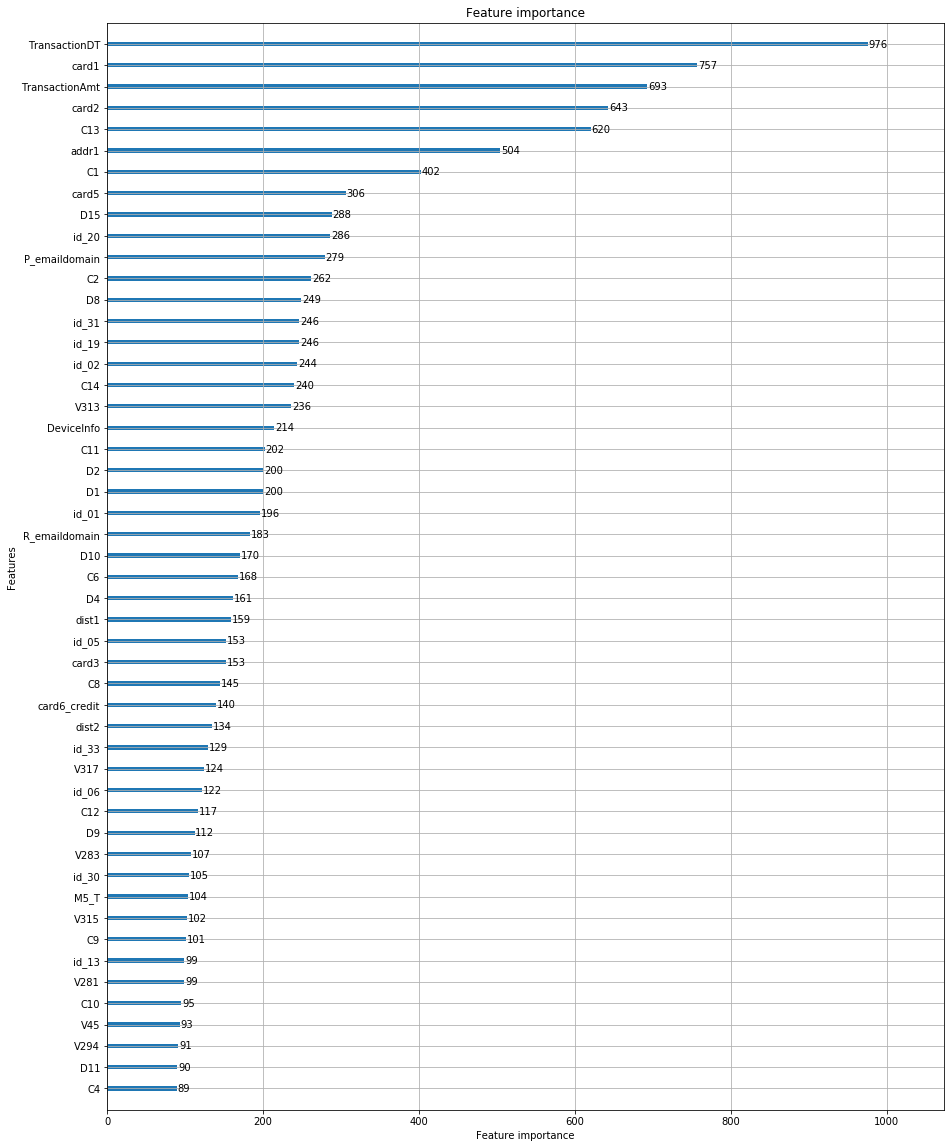

In [286]:
lgb.plot_importance(clf, figsize=(15,20), max_num_features=50)

From the feature importance plot, we know that the following features are important and worth looking at in detail:
- All card features (`card1`, `card2`, etc.): payment card information, such as card type, card category, issue bank, country, etc.
- `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)
- `TransactionAmt`: transaction payment amount in USD
- `addr1`: address
- `P_emaildomain`, `R_emaildomain`: purchaser and recipient email domain
- `C13`, `C1`, `C2`, `C14`: related with counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- `id_31`: Information about the user's browser.

There are more but these are the main ones we'll look at.

# Exploratory Data Analysis

> Note: I will not go very deep into EDA since this is not the focus of this notebook. I will provide a few examples as to how EDA prompted feature engineering decision that were made on the dataset as well as some basic visualizations.  

I recognize that in a real world scenario, a big chunk of the effort would be necessary for this stage. It is incredibly important to fully understand the data we are working with, and to work with different subject matter experts in the organization to validate our findings and to push our understanding further. I save this for when I'll try to win a competition ;)     

---
📣**Insights**: 

When dealing with a lot of data, it can be hard to visualize all the points on a graph. We can create a sampling function to deal with this issue. 
___

In [42]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

df_sample = get_sample(df_train, 500)

In [161]:
# Add 'isFraud' back to our dataframe for EDA purposes
df_train['isFraud'] = df_train_og['isFraud']

## Target variable: IsFraud

Only **20,663** or **3.5%** of transactions were fraudulent. 

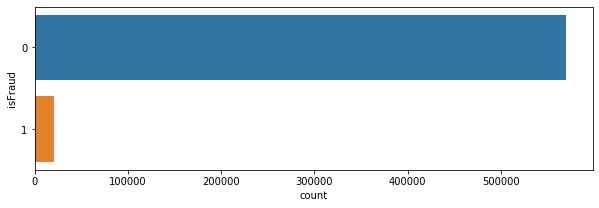

In [48]:
plt.figure(figsize=(10, 3))
sns.countplot(data=df_train, y= 'isFraud')

In [165]:
df_train.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

## Cards

Let's start by visualizing the relationships and distributions of our numerical Cards variables.

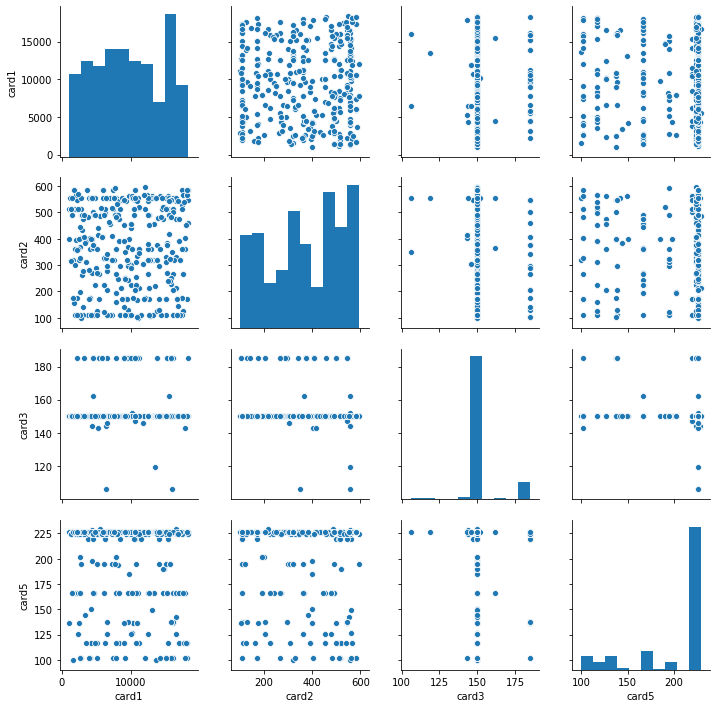

In [49]:
sns.pairplot(df_sample[['card1', 'card2', 'card3', 'card5']])

Not much can be interpreted other than 'card3' and 'card5' are dominated by one value.

**card4 & card5:**

Text(0.5, 1.0, 'Card6 Variable')

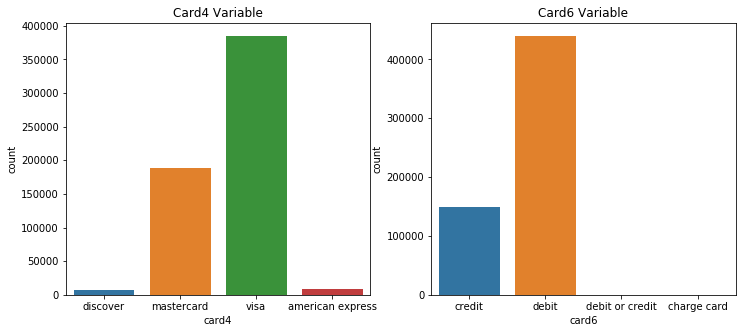

In [55]:
plt.figure(figsize=[12,5])

# card4
plt.subplot(1,2,1)
sns.countplot(data=df_train, x='card4')
plt.title('Card4 Variable')

# card6
plt.subplot(1,2,2)
sns.countplot(data=df_train, x='card6')
plt.title('Card6 Variable')

These variables will definitely be One Hot Encoded to make sure we're capturing all of their influence. 

## TransactionAMT 

As we'll see below, taking the log of the transaction amount really helps interpretation.

### Distribution

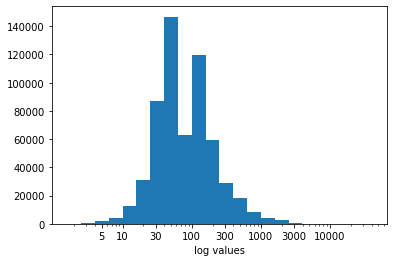

In [14]:
# Take the log transaction amount with plt.xscale('log') and adjust the bins and ticks accordingly
data = df_train.TransactionAmt
data_bins = 10 ** np.arange(0.2, np.log10(data.max())+0.2, 0.2)
plt.hist(data, bins=data_bins);
plt.xscale('log')
tick_loc = [5, 10, 30, 100, 300, 1000, 3000, 10000]
plt.xticks(tick_loc, tick_loc)
plt.xlabel('log values');

### Distribution of fraudulent VS non fraudulent transaction amounts

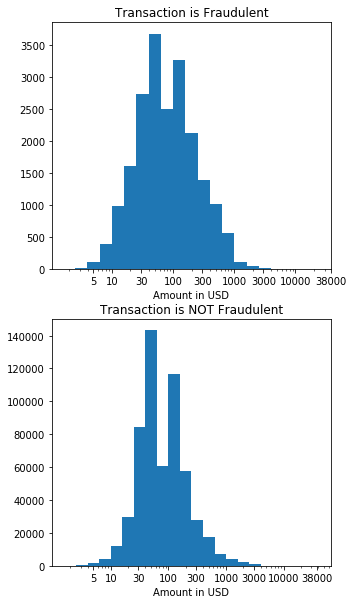

In [86]:
plt.figure(figsize=[5, 10])

plt.subplot(2,1,1)
data = df_train[df_train['isFraud'] == 1].TransactionAmt
log_bins = 10 ** np.arange(0.2, np.log10(data.max())+0.2, 0.2)
plt.hist(data, bins=log_bins);
plt.xscale('log')
tick_loc = [5, 10, 30, 100, 300, 1000, 3000, 10000, 38000]
plt.xticks(tick_loc, tick_loc)
plt.xlabel('Amount in USD');
plt.title('Transaction is Fraudulent');

plt.subplot(2,1,2)
data = df_train[df_train['isFraud'] == 0].TransactionAmt
log_bins = 10 ** np.arange(0.2, np.log10(data.max())+0.2, 0.2)
plt.hist(data, bins=log_bins);
plt.xscale('log')
tick_loc = [5, 10, 30, 100, 300, 1000, 3000, 10000, 38000]
plt.xticks(tick_loc, tick_loc)
plt.xlabel('Amount in USD');
plt.title('Transaction is NOT Fraudulent');

There doesn't seem to be a big different in distributions betweem fraudulent and non fraudulent amounts. 

## Transaction amount over time

In [ ]:
plt.plot(data=df_train, x='TransactionDT', y='TransactionAmt')

## 'Cxx' columns

We saw that some Cxx columns were important. Since they are only numeric, the only useful interpretation we could make is looking at their correlation and their distance from each other using en dendrogram


---
📣**Insights**: 

With hierarchical clustering, a neat feature is being able to visualize the distance between each point. This is called a dendrogram. You can find the code for it below. 
___

In [88]:
# Get all Cxx columns
c_columns = []
[c_columns.append(txt) for txt in df_train.columns if re.search('^[C]\d+', txt)]
        
print(c_columns)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


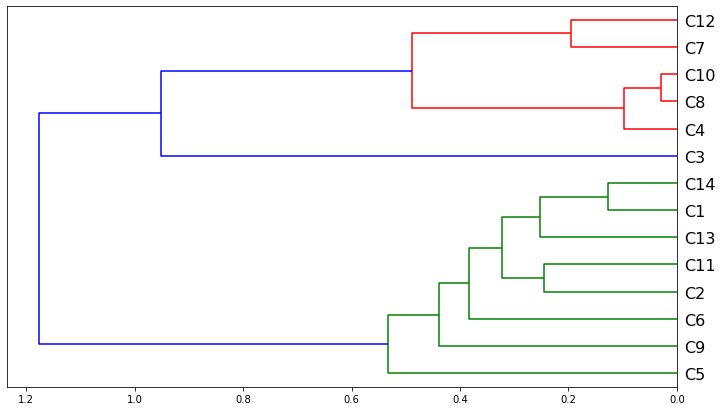

In [71]:
corr = np.round(scipy.stats.spearmanr(df_train[c_columns]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(12,7))
dendrogram = hc.dendrogram(z, labels=df_train[c_columns].columns, orientation='left', leaf_font_size=16)
plt.show()

Let's have a closer look at 'C10', 'C8' and 'C4'. 

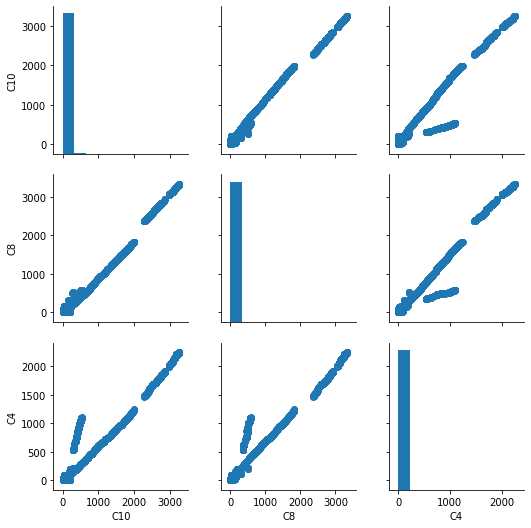

In [73]:
g = sns.PairGrid(data=df_train, vars = ['C10', 'C8', 'C4'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

'C10', 'C8' and 'C4' seem to be very close to each other. Maybe we can test removing 1 or 2 of them to limit colinearity (unless we'll only be doing tree based methods which doesn't care about colinearity much).  

## P_emaildomain and R_emaildomain

Text(0.5, 1.0, 'P_emaildomain distribution - Top 10')

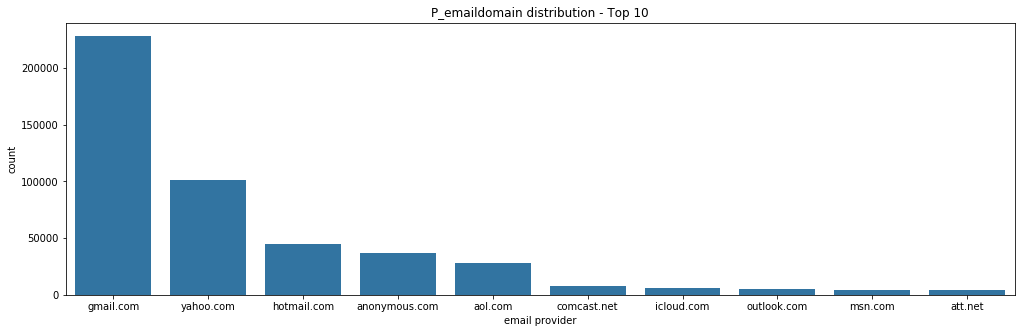

In [153]:
plt.figure(figsize=[17, 5])
base_color = sns.color_palette()[0]
sns.countplot(data=df_train, x='P_emaildomain', order=df_train.P_emaildomain.value_counts().iloc[:10].index, color=base_color);
plt.xlabel('email provider')
plt.title('P_emaildomain distribution - Top 10')

Text(0.5, 1.0, 'R_emaildomain distribution - Top 10')

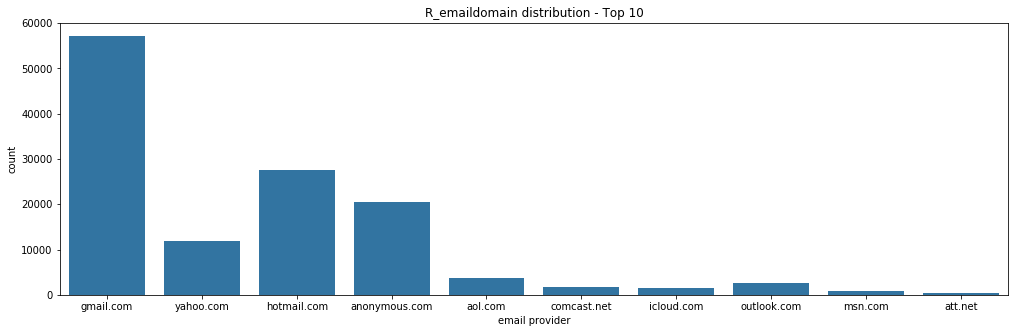

In [154]:
plt.figure(figsize=[17, 5])
sns.countplot(data=df_train, x='R_emaildomain', order=df_train.P_emaildomain.value_counts().iloc[:10].index, color=base_color);
plt.xlabel('email provider')
plt.title('R_emaildomain distribution - Top 10')

A lot of these email addresses can be grouped to limit the number of category for these variables (hotmail.com + outlook.com + msn.com = microsoft).  

## Device Info

In [79]:
df_train.DeviceInfo.value_counts()[:20]

Windows                        47722
iOS Device                     19782
MacOS                          12573
Trident/7.0                     7440
rv:11.0                         1901
rv:57.0                          962
SM-J700M Build/MMB29K            549
SM-G610M Build/MMB29K            461
SM-G531H Build/LMY48B            410
rv:59.0                          362
SM-G935F Build/NRD90M            334
SM-G955U Build/NRD90M            328
SM-G532M Build/MMB29T            316
ALE-L23 Build/HuaweiALE-L23      312
SM-G950U Build/NRD90M            290
SM-G930V Build/NRD90M            274
rv:58.0                          269
rv:52.0                          256
SAMSUNG                          235
SM-G950F Build/NRD90M            225
Name: DeviceInfo, dtype: int64

## Id_31 (browser versions)

In [288]:
df_train_og.id_31.value_counts()[:20]

chrome 63.0                   22000
mobile safari 11.0            13423
mobile safari generic         11474
ie 11.0 for desktop            9030
safari generic                 8195
chrome 62.0                    7182
chrome 65.0                    6871
chrome 64.0                    6711
chrome 63.0 for android        5806
chrome generic                 4778
chrome 66.0                    4264
edge 16.0                      4188
chrome 64.0 for android        3473
chrome 65.0 for android        3336
firefox 57.0                   3315
mobile safari 10.0             2779
chrome 66.0 for android        2349
chrome 62.0 for android        2097
edge 15.0                      1600
chrome generic for android     1158
Name: id_31, dtype: int64

Both `DeviceInfo` and `Id_31` can be split in order to harness more information.

# Feature Engineering

Now that we're going to build a serious model, let's first have a look at what we're dealing with in terms of null values in our data set. 

## Import our data once again to apply feature engineering

In [167]:
# load training_set
df_id_train = pd.read_csv(f'data/train_identity.csv')
df_trans_train = pd.read_csv(f'data/train_transaction.csv')

# load test_set
df_id_test = pd.read_csv(f'data/test_identity.csv')
df_trans_test = pd.read_csv(f'data/test_transaction.csv')

# Merge
df_train = df_trans_train.merge(df_id_train, on='TransactionID', how='left')
df_test = df_trans_test.merge(df_id_test, on='TransactionID', how='left')

In [168]:
# Set 'TransactionID' as index
df_train = df_train.set_index('TransactionID')
df_test = df_test.set_index('TransactionID')

## Identifying and quantifying null values

In [169]:
# Get the number of null values per columns
null_data = df_train.isnull().sum()[df_train.isnull().sum() != 0] 

# Create a DF out of the number of null values 
df_null = pd.DataFrame(null_data, columns = ['number_of_null'])

# Create a percentage column
df_null['percentage_of_null'] = df_null.number_of_null.values / len(df_train) 

# Get columns with over 90% null values
display_all(df_null[df_null['percentage_of_null'] > 0.9])


,number_of_null,percentage_of_null
dist2,552913,0.936284
D7,551623,0.934099
id_07,585385,0.991271
id_08,585385,0.991271
id_18,545427,0.923607
id_21,585381,0.991264
id_22,585371,0.991247
id_23,585371,0.991247
id_24,585793,0.991962
id_25,585408,0.991310


This table shows columns with over 90% null values. Let's clean this up a little and remove columns with 90% null values and over.

### Cleaning columns with too many null values and too many repeated values

In [170]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in df_train.columns if df_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    #cols_to_drop.remove('isFraud')
    return cols_to_drop

In [171]:
cols_to_drop = get_useless_columns(df_train)


More than 90% null: 12
More than 90% repeated value: 67


In [172]:
cols_to_drop = ['id_22', 'id_21', 'V132', 'id_27', 'V124', 'V134', 'V110', 'V135', 'V121', 'V296', 'V297', 'V309', 'id_07',
 'V103', 'V119', 'V318', 'id_25', 'V137', 'id_08', 'V118', 'V129', 'V293', 'V101', 'V136', 'V319', 'D7', 'V109', 'V116',
 'V106', 'C3', 'id_18', 'V298', 'V123', 'V305', 'V107', 'V108', 'V295', 'V311', 'V98', 'V133', 'V320', 'V125', 'V281',
 'V300', 'V102', 'id_23', 'V114', 'V117', 'V284', 'V286', 'V316',  'V105', 'V120', 'V104', 'V290', 'V301', 'dist2', 'id_26',
 'V112', 'V115', 'V321', 'id_24', 'V122', 'V113', 'V299', 'V111']

In [173]:
# Drop useless columns
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

In [174]:
df_train.shape

(590540, 367)

---
📣 **Insights**

I had tried submitting my results without this step. It turns out I scored 0.001 higher when I _didn't_ do this step. I guess the methodology I apply later on cleans out useless columns without needing to clean beforehand.

I am still doing this step for good measure because I end up with a slightly smaller dataframe which is preferable. 
___

## Extracting value from existing columns

Based on our findings in the EDA phase of the analysis, our dataframe has columns which can be cleaned up and split in order to extract more usefull information. 
> Note: every change we make to `df_train` also has to be made to `df_test`.

We'll first create a function that can:
- Split `DeviceInfo` column on `/` to create 2 new columns containing information about the device name and version. 
- Split `id_30` column on `' '` to create 2 new columns containing information about the OS and the version of the OS.
- Split `id_31` column on `' '` to create 2 new columsn containing information about the browser, and the browser version.
- Group all combinations of phone manufacturer into one common name to avoid having too many distinct phone manufacturer categories
- Map uncommon screensizes to 'Others', instead of having a bunch of screen sizes that didn't make sense.

Once our function is applied, we'll delete the columns that were split to avoid redundancy. 

In [175]:
import gc
def id_split(df):
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]

    df['OS_id_30'] = df['id_30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id_30'].str.split(' ', expand=True)[1]

    df['browser_id_31'] = df['id_31'].str.split(' ', expand=True)[0]
    df['version_id_31'] = df['id_31'].str.split(' ', expand=True)[1]

    # Group similar names into the same category
    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    
    # Change atypical screensizes with value_counts < 30 to 'Others'
    df.loc[df.id_33.isin(df.id_33.value_counts()[df.id_33.value_counts() < 30].index), 'id_33'] = "Others"
        
    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

In [176]:
# Apply the function to df_train and df_test
id_split(df_train)
id_split(df_test)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_38,DeviceType,DeviceInfo,device_name,device_version,OS_id_30,version_id_30,browser_id_31,version_id_31,had_id
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,...,F,mobile,ALE-L23 Build/HuaweiALE-L23,Huawei,HuaweiALE-L23,NaN,NaN,chrome,43.0,1
4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [177]:
# delete splited cols to remove redundant information 
split_col = ['DeviceInfo', 'id_30', 'id_31']
df_train.drop(split_col, axis=1, inplace=True)
df_test.drop(split_col, axis=1, inplace=True)

**More feature engineering based on feature importance and EDA**

- `TransactionAmt` looks like it would be more informative using its log values.
- We'll also create a new column `TransactionAmt_decimal` with only the decimal values of `TransactionAmt`.
- `TransactionDT` is a column related to time, but we have to apply some transformations in order to get the information we want. We'll extract `Transaction_day_of_week` and `Transaction_hour` and create 2 new columns. 

In [178]:
# Add feature: log of transaction amount
df_train['TransactionAmt_Log'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt_Log'] = np.log(df_test['TransactionAmt'])

# Add feature: day of the week 
df_train['Transaction_day_of_week'] = np.floor((df_train['TransactionDT'] / (3600 * 24) - 1) % 7)
df_test['Transaction_day_of_week'] = np.floor((df_train['TransactionDT'] / (3600 * 24) - 1) % 7)
                                               
# Add feature: hour of the day 
df_train['Transaction_hour'] = np.floor(df_train['TransactionDT'] / 3600) % 24
df_test['Transaction_hour'] = np.floor(df_test['TransactionDT'] / 3600) % 24

# Add feature: decimal part of the transaction amount
df_train['TransactionAmt_decimal'] = ((df_train['TransactionAmt'] - df_train['TransactionAmt'].astype(int)) * 1000).astype(int)
df_test['TransactionAmt_decimal'] = ((df_test['TransactionAmt'] - df_test['TransactionAmt'].astype(int)) * 1000).astype(int)

Valuable information can be extracted from `P_emaildomain` and `R_emaildomain`: 
- Group each variation of emails into different categories. Ex: msn.com, hotmail.es and outlook.com will all be maped to `microsoft`.
- Get the Top Level Domains of all email addresses (.es, .co.jp, .de, etc). 

In [179]:
# Dictionnary of email domains mapped to more general categories
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 
           'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 
           'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
           'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other',
            'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 
            'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 
          'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo',
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft',
          'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol',
          'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

# Perform the map change
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    # Get the TLDs of each email
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    # If 
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

Next we'll group the mean transaction per card. 

In [180]:
for card in ['card1', 'card2', 'card3', 'card4', 'card5']: 
    df_train['TransactionAmt_' + card + '_mean'] = df_train['TransactionAmt'] / df_train.groupby([card])['TransactionAmt'].transform('mean')
    df_test['TransactionAmt_' + card + '_mean'] = df_test['TransactionAmt'] / df_test.groupby([card])['TransactionAmt'].transform('mean')

Finally, we'll create interactions between important features.

In [181]:
# Create more random interactions between important features 
for feature in ['P_emaildomain_bin__TransactionAmt_Log', 'P_emaildomain_bin__Transaction_hour', 'card1__card2', 
                'card1__card3', 'card1__card5', 'addr1__addr2', 'addr1__card1', 
                'card1__P_emaildomain_bin', 'card1__C1', 'card1__TransactionAmt_Log',
                'V258__card1', 'V258__card2', 'V258__card3', 'V258__P_emaildomain_bin', 'V258__Transaction_hour', 
                 'version_id_31__device_version', 'version_id_31__device_name',
                 'id_33__device_name', 'id_33__device_version', 'id_33__browser_id_31', 
                'card1__card4', 'P_emaildomain_bin__card4', 'TransactionAmt_Log__card4', 
                'id_33__version_id_31']:
    f1, f2 = feature.split('__')
    df_train[feature] = df_train[f1].astype(str) + '_' + df_train[f2].astype(str)
    df_test[feature] = df_test[f1].astype(str) + '_' + df_test[f2].astype(str)

In [182]:
# Sanity Check
df_train.shape, df_test.shape

((590540, 408), (506691, 407))

## Apply the cleaning functions so that our new DataFrames are ready for training

In [ ]:
train_cats(df_train)
apply_cats(df_test)

In [ ]:
# Apply proc_df to transform our dataframe, remove NAs and create new columns with NAs
df_train, y, nas = proc_df(df_train, 'isFraud', max_n_cat=8)

In [ ]:
# Apply proc_df to the test dataframe
df_test, _, nas = proc_df(df_test, na_dict=nas, max_n_cat=8)

In [ ]:
# Create a copy for safe measures
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# Reducing Memory Usage and Saving Progress

---
📣 **Insights**

There are two very important ways to be more efficient with our time when working on a large data set. 
1. Save our DataFrame once the cleaning and feature engineering is done so that we don't have to run these steps again when we're continuing working where we left off. **A great library that efficiently stores pandas DataFrame objects on disk is [Feather-format](https://pypi.org/project/feather-format/).** Run this instead of going through all of your data cleaning and feature engineering every time you open your notebook.  


2. Reduce the memory usage of our data frame so that every time we run a model it goes faster. 
 
> Note: Feather format does not support saving columns in Float16. Therefore, we can't save with feather after running the reduce memory function.  
___

## Saving & Loading with Feather 

**Save and import the fully cleaned and feature engineered dataset.**

In [70]:
# Save
os.makedirs('tmp', exist_ok=True)

# Save df_train
df_train.reset_index().to_feather('tmp/ieee_fraud_detection_train') # index must be reset in order to use feather

# Save df_test
df_test.reset_index().to_feather('tmp/ieee_fraud_detection_test')

# Save the target variable normally because it is small 
np.save('tmp/y.npy', y)  

In [210]:
# Load
df_train = pd.read_feather('tmp/ieee_fraud_detection_train')
df_test = pd.read_feather('tmp/ieee_fraud_detection_test')
y = np.load('tmp/y.npy')

In [211]:
# Set 'TransactionID' as index again
df_train = df_train.set_index('TransactionID')
df_test = df_test.set_index('TransactionID')

**Save and load the DataFrame with feature_importance > 80**

In [220]:
# Save
os.makedirs('tmp', exist_ok=True)

# Save df_train
df_train.reset_index().to_feather('tmp/ieee_fraud_detection_train_pruned') # index must be reset in order to use feather

# Save df_test
df_test.reset_index().to_feather('tmp/ieee_fraud_detection_test_pruned')

# Save the target variable normally because it is small 
np.save('tmp/y.npy', y)

In [16]:
# Load
df_train = pd.read_feather('tmp/ieee_fraud_detection_train_pruned')
df_test = pd.read_feather('tmp/ieee_fraud_detection_test_pruned')
y = np.load('tmp/y.npy')

In [17]:
# Set 'TransactionID' as index again
df_train = df_train.set_index('TransactionID')
df_test = df_test.set_index('TransactionID')

In [41]:
df_train.shape, df_test.shape

((590540, 797), (506691, 796))

## Reduce memory usage

In [221]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [222]:
reduce_mem_usage(df_train)
reduce_mem_usage(df_test)

Memory usage of dataframe is 1452.45 MB
Memory usage after optimization is: 507.99 MB
Decreased by 65.0%
Memory usage of dataframe is 1246.22 MB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


Memory usage after optimization is: 446.49 MB
Decreased by 64.2%


,TransactionDT,addr1__card1,card1,P_emaildomain_bin__TransactionAmt_Log,TransactionAmt_card1_mean,card2,TransactionAmt_card2_mean,P_emaildomain_bin__Transaction_hour,card1__card2,V258__card2,...,V76_na,V15,V148,V16,V254,M1_T,V177,V235,V198,V175
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,3894,10409,6007,0.339355,111.0,0.209595,96,394,1693,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3663550,18403263,19590,4272,182,0.333496,111.0,0.321289,1,9754,1693,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3663551,18403310,33954,4476,21061,1.485352,574.0,0.987305,120,9911,2156,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3663552,18403310,10486,10989,10924,2.968750,360.0,2.894531,96,932,1942,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3663553,18403317,15046,18018,7948,0.567383,452.0,0.566406,96,7377,2034,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170235,34214279,17936,13832,8845,2.771484,375.0,2.882812,112,3565,1957,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4170236,34214287,38988,3154,15903,0.360107,408.0,0.351807,136,8816,304,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4170237,34214326,24736,16661,18207,0.424072,490.0,0.350586,136,6138,2072,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# sanity check 
df_train.info(verbose=True)

# LGBM Hyperparameter Tuning

I tested a few models such as XGBoost, RandomForests and AdaBoost. LGBM was the one that yielded the best results and is the one I  will be demonstrating here.

Let's apply grid search to find the best parameters. 

## Grid Search

> Note: My approach was to grid search a few hyperparameters to get a general idea of what works best. I then fine tuned the hyperparameters one by one fitting the model and comparing at the AUC score.  

In [106]:
gridparams = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'num_leaves': [20, 25, 31, 35],
    'subsample': [0.7, 1],
    'metric': ['auc'],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'colsample_bytree' : [0.64, 0.66, 0.7, 1],
    'reg_alpha': [1, 1.2, 1.4]
}

In [156]:
search = GridSearchCV(model, gridparams, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  7.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=0.7,
                                      importance_type='split',
                                      learning_rate=0.008, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=50,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.2, reg_lambda=0.4,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_b

## Using the best model

These are the parameters I am using for the model. Note: they are a combination of hyperparameters taken from a public kernel in Kaggle and some that I have found myself. 

In [212]:
params = {'num_leaves': 600,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.4,
          'bagging_fraction': 0.6,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'max_bin': 500
         }

Create a sample training and validation dataset to fine tuning parameters and reduce training time.

In [198]:
# Create a training and validation data set. 
n = 50_000
m = 65_000
X_train, X_valid = split_vals_sample(df_train, n, m)
y_train, y_valid = split_vals_sample(y, n, m)

print(F'X_train: {len(X_train)}, X_valid: {len(X_valid)}, y_train: {len(y_train)}, y_valid: {len(y_valid)}')

X_train: 50000, X_valid: 15000, y_train: 50000, y_valid: 15000


In [214]:
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

%time clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.952552	valid_1's auc: 0.906107
[400]	training's auc: 0.969201	valid_1's auc: 0.916365
[600]	training's auc: 0.983639	valid_1's auc: 0.92596
[800]	training's auc: 0.991602	valid_1's auc: 0.932032
[1000]	training's auc: 0.99581	valid_1's auc: 0.935288
[1200]	training's auc: 0.997993	valid_1's auc: 0.936999
[1400]	training's auc: 0.999073	valid_1's auc: 0.937526
[1600]	training's auc: 0.999591	valid_1's auc: 0.937742
[1800]	training's auc: 0.999824	valid_1's auc: 0.937923
[2000]	training's auc: 0.999927	valid_1's auc: 0.93808
[2200]	training's auc: 0.999971	valid_1's auc: 0.938182
[2400]	training's auc: 0.999989	valid_1's auc: 0.938316
[2600]	training's auc: 0.999996	valid_1's auc: 0.938344
[2800]	training's auc: 0.999999	valid_1's auc: 0.93844
[3000]	training's auc: 1	valid_1's auc: 0.938445
[3200]	training's auc: 1	valid_1's auc: 0.938323
Early stopping, best iteration is:
[2867]	training's auc: 0.999

# Feature Selection with Feature Importance

## Feature importance

---
📣 **Insights**

We can improve the model by removing all the columns that have a feature importance under a specified number. By removing them and training the model again with the same parameters, we end up with a (slightly) better AUC score. 
___

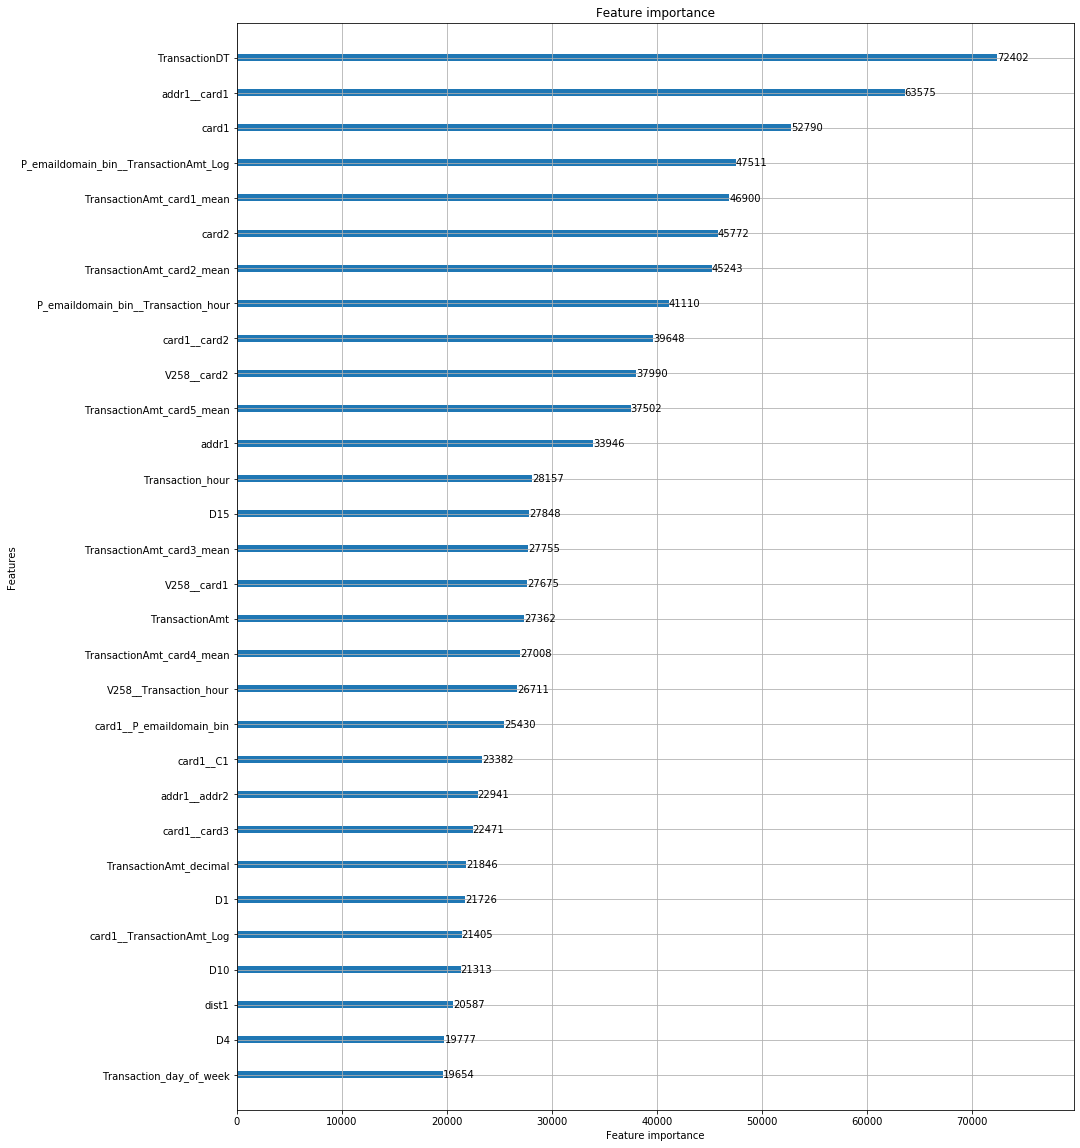

In [215]:
# Plot top feature importances
lgb.plot_importance(clf, figsize=(15,20), max_num_features=30)

In [216]:
# Create a function to get feature importance
def feature_importance(df, m):
    fi = pd.DataFrame({'cols': df.columns, 'feature-importances': m.feature_importance(importance_type='split')})\
                        .sort_values(by='feature-importances', ascending=False)
    return fi

fi = feature_importance(df_train, clf)

Plot feature_importance distribution

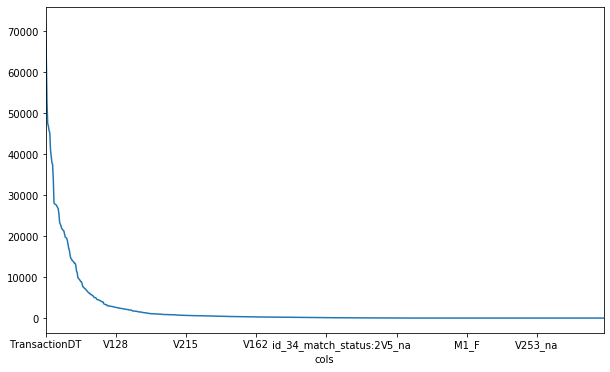

In [217]:
fi.plot('cols', 'feature-importances', figsize=(10,6), legend=False);

## Keep features only with importance > 80

In [218]:
# Keep only the columns with over 80 importance
df_keep = fi[fi['feature-importances'] > 80]
df_keep.cols

df_train = df_train[df_keep.cols]
df_train.shape

(590540, 413)

In [219]:
# Apply the same treatment to our training set
df_test = df_test[df_keep.cols]
df_test.shape

(506691, 413)

Now that we've done some feature selection, we can retrain our model and find what our score is. Again, we have the choice of training on a sample of the data if we want to iterate quickly or train on the full data set.  

In [223]:
# Create a training and validation data set
n = 500_000
X_train, X_valid = split_vals(df_train, n)
y_train, y_valid = split_vals(y, n)

print(F'X_train: {len(X_train)}, X_valid: {len(X_valid)}, y_train: {len(y_train)}, y_valid: {len(y_valid)}')

X_train: 500000, X_valid: 90540, y_train: 500000, y_valid: 90540


In [108]:
# Create a sample training and validation data set
n = 50_000
m = 65_000
X_train, X_valid = split_vals2(df_train, n, m)
y_train, y_valid = split_vals2(y, n, m)

print(F'X_train: {len(X_train)}, X_valid: {len(X_valid)}, y_train: {len(y_train)}, y_valid: {len(y_valid)}')

X_train: 50000, X_valid: 15000, y_train: 50000, y_valid: 15000


In [109]:
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.975373	valid_1's auc: 0.903197
[400]	training's auc: 0.989792	valid_1's auc: 0.910813
[600]	training's auc: 0.99714	valid_1's auc: 0.917634
[800]	training's auc: 0.999423	valid_1's auc: 0.922342
[1000]	training's auc: 0.999903	valid_1's auc: 0.924055
[1200]	training's auc: 0.999987	valid_1's auc: 0.924778
[1400]	training's auc: 0.999999	valid_1's auc: 0.925839
[1600]	training's auc: 1	valid_1's auc: 0.926448
[1800]	training's auc: 1	valid_1's auc: 0.926727
[2000]	training's auc: 1	valid_1's auc: 0.926597
Early stopping, best iteration is:
[1657]	training's auc: 1	valid_1's auc: 0.92653


# Cross validation with TimeSeriesSplit and StratifiedKFold

The reference for the following code can be found here: https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm

We will try training the model using 2 different kinds of cross validation techniques: Time Series Split and Stratified K Fold. 

The results on the test set didn't end up being better than when I used my initial validation set. 

With more time, I would have tried different numbers of folds for each cross validation technique and submitted my results to Kaggle. I did not end up doing this for this competition however. 

## Cross validation 1: TimeSeriesSplit 

In [15]:
# TimeSeriesSplit
NFOLDS = 5
folds = TimeSeriesSplit(n_splits=NFOLDS)

In [ ]:
# Kfold setup
columns = df_train.columns
splits = folds.split(df_train, y)
y_preds = np.zeros(df_test.shape[0])
y_oof = np.zeros(df_train.shape[0])
score = 0
y = df_train_og.sort_values('TransactionDT')['isFraud']

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [81]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = df_train[columns].iloc[train_index], df_train[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(df_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.975398	valid_1's auc: 0.888969
[400]	training's auc: 0.993282	valid_1's auc: 0.898068
[600]	training's auc: 0.998616	valid_1's auc: 0.902809
[800]	training's auc: 0.999757	valid_1's auc: 0.903349
[1000]	training's auc: 0.999962	valid_1's auc: 0.903437
[1200]	training's auc: 0.999995	valid_1's auc: 0.903001
Early stopping, best iteration is:
[869]	training's auc: 0.999865	valid_1's auc: 0.903607
Fold 1 | AUC: 0.9036067372632375
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.974534	valid_1's auc: 0.907594
[400]	training's auc: 0.991076	valid_1's auc: 0.916753
[600]	training's auc: 0.99727	valid_1's auc: 0.921575
[800]	training's auc: 0.999205	valid_1's auc: 0.922767
[1000]	training's auc: 0.999786	valid_1's auc: 0.922391
[1200]	training's auc: 0.999947	valid_1's auc: 0.921826
Early stopping, best iteration is:
[797]	training's auc: 0.999189	valid_1's auc: 0.92279

## Cross validation 2: StratifiedKFold

In [224]:
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS)

In [229]:
columns = df_train.columns
splits = folds.split(df_train, y)
y_preds = np.zeros(df_test.shape[0])
y_oof = np.zeros(df_train.shape[0])
score = 0
y = df_train_og.sort_values('TransactionDT')['isFraud']

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [230]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = df_train[columns].iloc[train_index], df_train[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(df_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.95374	valid_1's auc: 0.882492
[400]	training's auc: 0.971449	valid_1's auc: 0.893088
[600]	training's auc: 0.985085	valid_1's auc: 0.900604
[800]	training's auc: 0.992593	valid_1's auc: 0.906529
[1000]	training's auc: 0.996345	valid_1's auc: 0.909934
[1200]	training's auc: 0.99821	valid_1's auc: 0.911887
[1400]	training's auc: 0.999138	valid_1's auc: 0.912406
[1600]	training's auc: 0.999578	valid_1's auc: 0.911496
[1800]	training's auc: 0.999791	valid_1's auc: 0.909049
Early stopping, best iteration is:
[1339]	training's auc: 0.998919	valid_1's auc: 0.912508
Fold 1 | AUC: 0.9125077439911924
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.951879	valid_1's auc: 0.865478
[400]	training's auc: 0.969892	valid_1's auc: 0.86197
Early stopping, best iteration is:
[20]	training's auc: 0.931759	valid_1's auc: 0.888944
Fold 2 | AUC: 0.8889436348654365
Training until valida

# Ensembling/Stacking models

The reference for the following code and explanations can be found here: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python.

---
📣 **Insights**

For an excellent article on stacking and ensembling, refer to the de-facto Must read article: [Kaggle Ensembling Guide](https://mlwave.com/kaggle-ensembling-guide/).

In a nutshell stacking uses as a first-level (base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions. Stacking has been responsible for many Kaggle competition wins. 
___

Here is a very interesting extract of a paper of the creator of stacking: Wolpert (1992) Stacked Generalization:

> It is usually desirable that the level 0 generalizers are of all “types”, and not just simple variations of one another (e.g., we want surface-fitters, Turing-machine builders, statistical extrapolators, etc., etc.). In this way all possible ways of examining the learning set and trying to extrapolate from it are being exploited. This is part of what is meant by saying that the level 0 generalizers should “span the space”.

>[…] stacked generalization is a means of non-linearly combining generalizers to make a new generalizer, to try to optimally integrate what each of the original generalizers has to say about the learning set. The more each generalizer has to say (which isn’t duplicated in what the other generalizer’s have to say), the better the resultant stacked generalization. 



## Helper Class

Here we'll invoke the use of Python's classes to help make it more convenient for us. 

In [225]:
# Some useful parameters which will come in handy later on
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)
splits = kf.split(df_train) # new

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

## Out-of-Fold Predictions

As alluded to above stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [226]:
def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(splits):
        x_tr = X_train[train_index]
        y_tr = y_train[train_index]
        x_te = X_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our base first-level models

Let's prepare 3 learning models as our first level classification: Random Forest, Extra Trees, Gradient Boosting. 

In [227]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':100,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 100,
     'max_features': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 5,
    'verbose': 0
}

In [228]:
# Create 3 objects that represent our 3 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

In [229]:
# Create Numpy arrays of train, test and target (isFraud) dataframes to feed into our models
y_train = df_train_og['isFraud'].ravel()
X_train = df_train.values # Creates an array of the train data
X_test = df_test.values # Creats an array of the test data

## Train our classifiers and generate our first level prediction

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions.

In [197]:
# Train our 3 classifiers
randf_oof_train, randf_oof_test = get_oof(rf,X_train, y_train, X_test) # Random Forest
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost

## Second-level predictions from the first-level output


We are having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [235]:
base_predictions_train = pd.DataFrame( {'RandomForest': randf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })

In [236]:
base_predictions_train

,RandomForest,ExtraTrees,GradientBoost
0,0.035713,0.042941,0.033789
1,0.018891,0.035888,0.024017
2,0.017327,0.020838,0.018982
3,0.066818,0.035453,0.050022
4,0.032791,0.054380,0.025724
...,...,...,...
590535,0.017764,0.037241,0.015711
590536,0.017590,0.024020,0.017706
590537,0.013963,0.010343,0.013736
590538,0.051332,0.053787,0.046826


In [246]:
X_train = np.concatenate(( et_oof_train, randf_oof_train, gb_oof_train), axis=1) 
X_test = np.concatenate(( et_oof_test, randf_oof_test, gb_oof_test), axis=1) 

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

In [252]:
df_stack1_train = pd.DataFrame(X_train, columns=['ExtraTrees', 'RandomForest', 'GradientBoost'])
df_stack1_test = pd.DataFrame(X_test, columns=['ExtraTrees', 'RandomForest', 'GradientBoost'])

In [256]:
df_stack1_test

,ExtraTrees,RandomForest,GradientBoost
0,0.011688,0.014909,0.014506
1,0.020979,0.017629,0.018097
2,0.024601,0.017673,0.017714
3,0.010447,0.014300,0.014226
4,0.012471,0.015959,0.014018
...,...,...,...
506686,0.036896,0.029405,0.019036
506687,0.063107,0.040528,0.023319
506688,0.020996,0.016918,0.017431
506689,0.021273,0.016918,0.017431


In [262]:
# Create validation set using df_stack1_train
n = 500_000
X_train, X_valid = split_vals(df_stack1_train, n)
y_train, y_valid = split_vals(y, n)

print(F'X_train: {len(X_train)}, X_valid: {len(X_valid)}, y_train: {len(y_train)}, y_valid: {len(y_valid)}')

X_train: 500000, X_valid: 90540, y_train: 500000, y_valid: 90540


In [273]:
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.893422	valid_1's auc: 0.856989
[400]	training's auc: 0.906715	valid_1's auc: 0.856129
[600]	training's auc: 0.915281	valid_1's auc: 0.854546
Early stopping, best iteration is:
[110]	training's auc: 0.884951	valid_1's auc: 0.857647


I wasn't able to get a good AUC score using this technique. This is because I had too few base models and that they weren't very good to begin with.  

# Easy ensembling with weighted average

**Easy ensembling**: the most basic and convenient way to ensemble is to ensemble Kaggle submission CSV files. We only need the predictions on the test set for these methods — no need to retrain a model. This makes it a quick way to ensemble already existing model predictions. Here we'll use a simple weighted average of our best submissions. 

> Weighting and averaging prediction files easy, but it’s not the only method that the top Kagglers are using. The serious gains start with stacking and blending. This is not included as it is an advanced technique that I have yet to try out. 

In [ ]:
df0 = pd.read_csv('julienbeaulieu_submission5_fullcols.csv')
df1 = pd.read_csv('julienbeaulieu_submission7.csv')
df2 = pd.read_csv('julienbeaulieu_submission8_noTransactionID.csv')
df3 = pd.read_csv('julienbeaulieu_submission11.csv')
df4 = pd.read_csv('julienbeaulieu_submission12.csv')
df5 = pd.read_csv('julienbeaulieu_submission13.csv')
df6 = pd.read_csv('julienbeaulieu_submission17.csv')
df7 = pd.read_csv('julienbeaulieu_submission18.csv')

In [ ]:
blend1 = df0['isFraud']*0.12 + df1['isFraud']*0.12 + df2['isFraud']*0.12 + df3['isFraud']*0.16 +\
            df4['isFraud']*0.12 + df5['isFraud']*0.12 + df6['isFraud']*0.12 + df7['isFraud']*0.12

In [255]:
blend = pd.DataFrame(blend1, columns=['isFraud'])
blend.insert(0, 'TransactionID', df0['TransactionID'])

In [258]:
blend

,TransactionID,isFraud
0,3663549,0.001072
1,3663550,0.001469
2,3663551,0.002976
3,3663552,0.001571
4,3663553,0.001565
...,...,...
506686,4170235,0.011621
506687,4170236,0.003893
506688,4170237,0.002303
506689,4170238,0.004137


In [ ]:
# create submission file
blend.to_csv('julienbeaulieu_submission26.csv', index=False)

# Producing the Submission file

In [232]:
ids = df_trans_test.TransactionID.values
prob_test = clf.predict(df_test)

In [233]:
submit = pd.DataFrame()
submit['TransactionID'] = ids
submit['isFraud'] = prob_test # y_preds

In [234]:
# View the first lines of the submission DataFrame
submit

,TransactionID,isFraud
0,3663549,0.000064
1,3663550,0.000050
2,3663551,0.000154
3,3663552,0.000090
4,3663553,0.000168
...,...,...
506686,4170235,0.000705
506687,4170236,0.000222
506688,4170237,0.000192
506689,4170238,0.000227


In [235]:
submit.to_csv('julienbeaulieu_submission24.csv', index=False)

# Limitations and going further

This notebook was created thanks for a lot of other notebooks, forum discussion and code from the Introduction to Machine Learning for Coders Fastai course. 

While my final score for this competition wasn't great, I am convinced that with more effort I could have improved it.

Here are some ideas to implement to improve the work:

- Adding external sources of data to enrich the current data set.
- Better exploratory data analysis to have a better understanding of the data. My feature engineering would have been better as a result.  
- Better feature selection - I opted to take all the features above 80 feature importance in my LGBM model. I could have tried different feature importance thresholds and different stepwise techniques for choosing features.  
- Ensemble stacking:
    - Adding a much more varied number of algorithms in the first level such as Neural Nets, SVM, KNN, etc. 
    - My base models for XGBoost, Random Forests, and Extra Trees in the first level were not very good. More time could have been spent optimizing them before the stacking procedure. 
- Using techniques to better deal with the imbalanced dataset - over & undersampling. 
- Standardizing the dataset made results worse. I didn't dig deeply as to why and if I was doing it correctly. 
- Cross validation: Trying a different numbers of folds for each cross validation technique. I only tried with 5 folds for both TimeSeriesSplit and StratifiedKFold. 
- Combining crossvalidation, stacking and blending for the ultimate model. 